In [ ]:
# Reading the MUR SST Icechunk Virtual Store with xarray and zarr-python

This notebook demonstrates how to open, subset, and plot the MUR SST virtual dataset using either xarray or zarr-python. Documentation for this dataset can be found [in this design doc](https://github.com/earth-mover/icechunk-nasa/blob/main/design-docs/mursst-virtual-icechunk-store.md).

It also includes a demonstration of visualizing the data with hvplot.

## Step 0. Ensure required version libraries are installed

In [3]:
#!pip install icechunk==0.2.15 xarray==2025.4.0 zarr==3.0.8 earthaccess==0.14.0 kerchunk==0.2.8 virtualizarr==1.3.2 fsspec==2025.7.0

In [3]:
pip list | grep -E "zarr|^xarray|virtualizarr|icechunk|kerchunk|boto3|fsspec|boto3"

boto3                         1.39.11
fsspec                        2025.7.0
icechunk                      0.2.15
kerchunk                      0.2.8
virtualizarr                  1.3.2
xarray                        2025.4.0
zarr                          3.0.8
Note: you may need to restart the kernel to use updated packages.


In [4]:
import boto3
from datetime import datetime, timedelta
import earthaccess
import fsspec
import hvplot.xarray
import holoviews as hv
from holoviews import opts
import matplotlib.pyplot as plt
import numpy as np
import panel as pn

import xarray as xr
import zarr
import icechunk

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from typing import Optional

## Step 1. Set zarr runtime configuration

Async and threading operations can be set via zarr.config. Please also see [zarr-python runtime configuration documentation](https://zarr.readthedocs.io/en/stable/user-guide/config.html).

* `async.concurrency` controls how many chunks can be fetched asynchronously at once.
* `threading.max_workers` determines how many threads handle the decompression or processing of those fetched chunks.

The default setting for `threading.max_workers` is `None` so presumably this uses all threads available.

In [5]:
# concurrency=300 seems to be a sweeet spot for smaller EC2s. Fast open time of a few secconds for MUR.
zarr.config.set({
    'async': {'concurrency': 300, 'timeout': None},
    'threading': {'max_workers': 4}
})

## Step 2. Set other variables

In [6]:
bucket = 'nasa-eodc-public'
store_name = "MUR-JPL-L4-GLOB-v4.1-virtual-v1"

# Gulf of Tehuantepec, MX
lat_min = 14.
lat_max = 15.
lon_min = -96.
lon_max = -95.

lat_range = (lat_min, lat_max)
lon_range = (lon_min, lon_max)

start_date = '2003-01-01'
end_date = '2023-12-31'
time_range =(start_date, end_date)

lat_min = -90
lon_min = -180
resolution = 0.01
ea_creds = None

#print(bucket)

## Step 3. Fetch earthaccess credentials

Note: You can skip this step if you have direct bucket access to `s3://podaac-ops-cumulus-protected/`.

In [7]:
s3 = boto3.client("s3")
#bucket_name = helpers.bucket
bucket_name = bucket
print(bucket_name)

earthaccess.login()
ea_creds = earthaccess.get_s3_credentials(daac='PODAAC')

nasa-eodc-public


## Step 4. Initialize the repo

In [8]:
# get_repo subroutine

def get_repo(bucket_name: str, store_name: str, ea_creds: Optional[dict] = None):
    storage = icechunk.s3_storage(
        bucket=bucket_name,
        prefix=f"icechunk/{store_name}",
        anonymous=True
    )

    config = icechunk.RepositoryConfig.default()
    config.set_virtual_chunk_container(icechunk.VirtualChunkContainer("s3", "s3://", icechunk.s3_store(region="us-west-2")))

    repo_config = dict(
        storage=storage,
        config=config,
    )
    if ea_creds:
        earthdata_credentials = icechunk.containers_credentials(
            s3=icechunk.s3_credentials(
                access_key_id=ea_creds['accessKeyId'],
                secret_access_key=ea_creds['secretAccessKey'],
                session_token=ea_creds['sessionToken']
            )
        )
        repo_config['virtual_chunk_credentials'] = earthdata_credentials
    return icechunk.Repository.open(**repo_config)

In [ ]:
# get_repo subroutine --dont run this

def get_repo(bucket_name: str, store_name: str, ea_creds: Optional[dict] = None):
    storage = icechunk.s3_storage(
        bucket=bucket_name,
        prefix=f"icechunk/{store_name}",
        anonymous=True
    )

    config = icechunk.RepositoryConfig.default()
    #config.set_virtual_chunk_container(icechunk.VirtualChunkContainer("s3", "s3://", icechunk.s3_store(region="us-west-2")))
    config.set_virtual_chunk_container(icechunk.VirtualChunkContainer("s3://nasa-eodc-public/", icechunk.s3_store(region="us-west-2")))


    repo_config = dict(
        storage=storage,
        config=config,
    )
    if ea_creds:
        earthdata_credentials = icechunk.containers_credentials(
            {"s3://nasa-eodc-public/": icechunk.s3_credentials(
                access_key_id=ea_creds['accessKeyId'],
                secret_access_key=ea_creds['secretAccessKey'],
                session_token=ea_creds['sessionToken'] )
            }
        )
        repo_config['authorize_virtual_chunk_access'] = earthdata_credentials
    return icechunk.Repository.open(**repo_config)

In [ ]:
credentials = icechunk.containers_credentials(
    { "s3://my_s3_bucket": icechunk.s3_credentials(bucket="my-s3-bucket", region="us-east-1"),
      "s3://my_other_s3_bucket": icechunk.s3_credentials(bucket="my-other-s3-bucket", region="us-west-2"),
    }
)

repo = icechunk.Repository.open(
    storage=storage,
    config=config,
    authorize_virtual_chunk_access=credentials,
)

In [9]:
#repo = helpers.get_repo(bucket_name=bucket, store_name=store_name, ea_creds=ea_creds)
repo = get_repo(bucket_name=bucket, store_name=store_name, ea_creds=ea_creds)
session = repo.readonly_session(branch="main")

## Step 5 Option 1: Read and plot with `xarray`

In [96]:
%%time
mur_ds = xr.open_zarr(session.store, consolidated=False, zarr_format=3)

CPU times: user 7.17 s, sys: 1.69 s, total: 8.86 s
Wall time: 5.69 s


In [83]:
print(mur_ds)

<xarray.Dataset> Size: 146TB
Dimensions:           (time: 8037, lat: 17999, lon: 36000)
Coordinates:
  * lat               (lat) float32 72kB -89.99 -89.98 -89.97 ... 89.98 89.99
  * lon               (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0
  * time              (time) datetime64[ns] 64kB 2002-06-01T09:00:00 ... 2024...
Data variables:
    analysed_sst      (time, lat, lon) float64 42TB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 42TB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    mask              (time, lat, lon) float32 21TB dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 42TB dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.7
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references: 

In [97]:
%%time
#mur_subset = mur_ds.analysed_sst.sel(lat=slice(*lat_range), lon=slice(*lon_range), time=slice(*time_range)).mean(["lat", "lon"]).rolling(time=7, center=True).mean().load()
mur_subset = mur_ds.analysed_sst.sel(lat=slice(*lat_range), lon=slice(*lon_range), time=slice(*time_range)).mean(["lat", "lon"]).resample(time="W").mean().load()

CPU times: user 3min 10s, sys: 27.8 s, total: 3min 38s
Wall time: 6min 42s


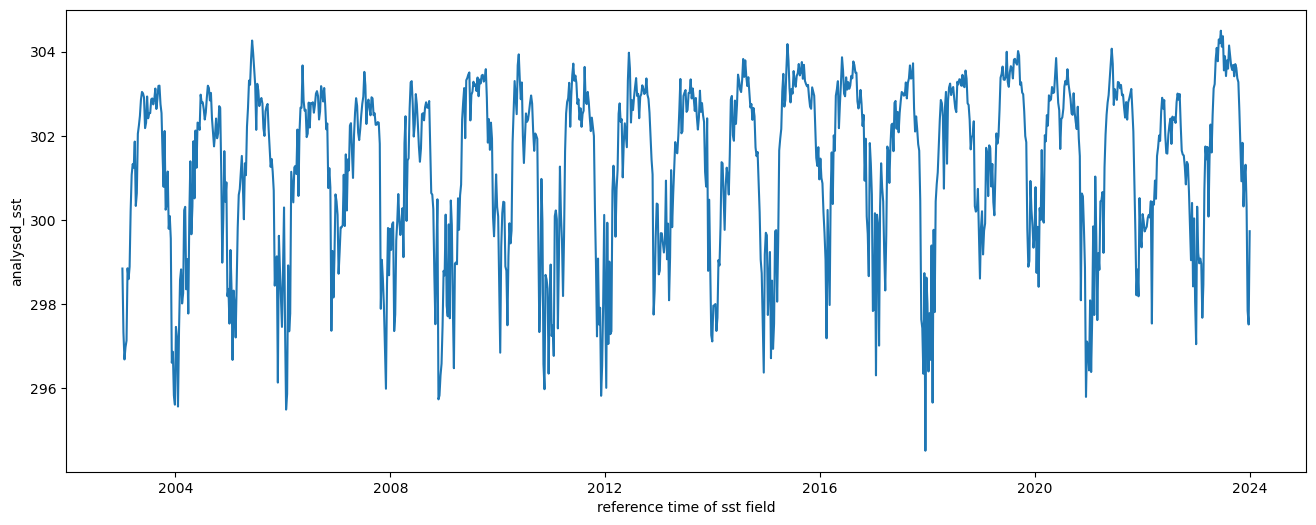

In [68]:
fig = plt.figure(figsize=(16, 6)) 
ax = fig.add_subplot() 
mur_subset.plot()
plt.show()

In [ ]:
# Open the OSTIA VDS created with virtualizarr

In [98]:
fs = earthaccess.get_s3_filesystem(daac="PODAAC")

In [99]:
%%time
vds_link = "https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/virtual_collections/OSTIA-UKMO-L4-GLOB-REP-v2.0/OSTIA-UKMO-L4-GLOB-REP-v2.0_virtual_s3.json"
ostia_ds = xr.open_dataset(
    vds_link,
    engine="kerchunk",
    chunks={},
    backend_kwargs={
        "storage_options": {
            "remote_protocol": "s3",
            "remote_options": fs.storage_options
        }
    }
)

CPU times: user 4.46 s, sys: 399 ms, total: 4.86 s
Wall time: 9.45 s


In [51]:
print(ostia_ds)

<xarray.Dataset> Size: 11TB
Dimensions:           (time: 15340, lat: 3600, lon: 7200)
Coordinates:
  * time              (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 202...
  * lat               (lat) float32 14kB -89.97 -89.93 -89.88 ... 89.93 89.97
  * lon               (lon) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
Data variables:
    analysed_sst      (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
    mask              (time, lat, lon) float32 2TB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
Attributes: (12/39)
    Conventions:                CF-1.4, ACDD-1.3
    title:                      Global SST & Sea Ice Analysis, L4 OSTIA, 0.05...
    summary:                    A merged, multi-sensor L4 Foundation SST p

In [100]:
%%time
ostia_subset = ostia_ds.analysed_sst.sel(lat=slice(*lat_range), lon=slice(*lon_range), time=slice(*time_range)).mean(["lat", "lon"]).resample(time="W").mean().load()

CPU times: user 13min 37s, sys: 16.1 s, total: 13min 53s
Wall time: 11min 36s


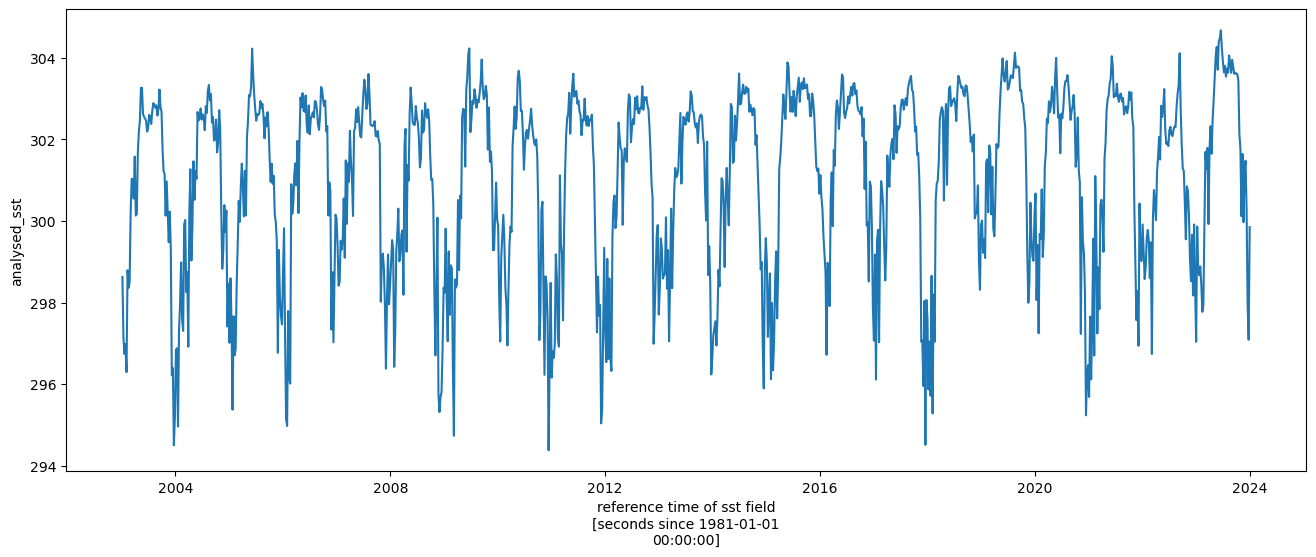

In [101]:
fig = plt.figure(figsize=(16, 6)) 
ax = fig.add_subplot() 
ostia_subset.plot()
plt.show()

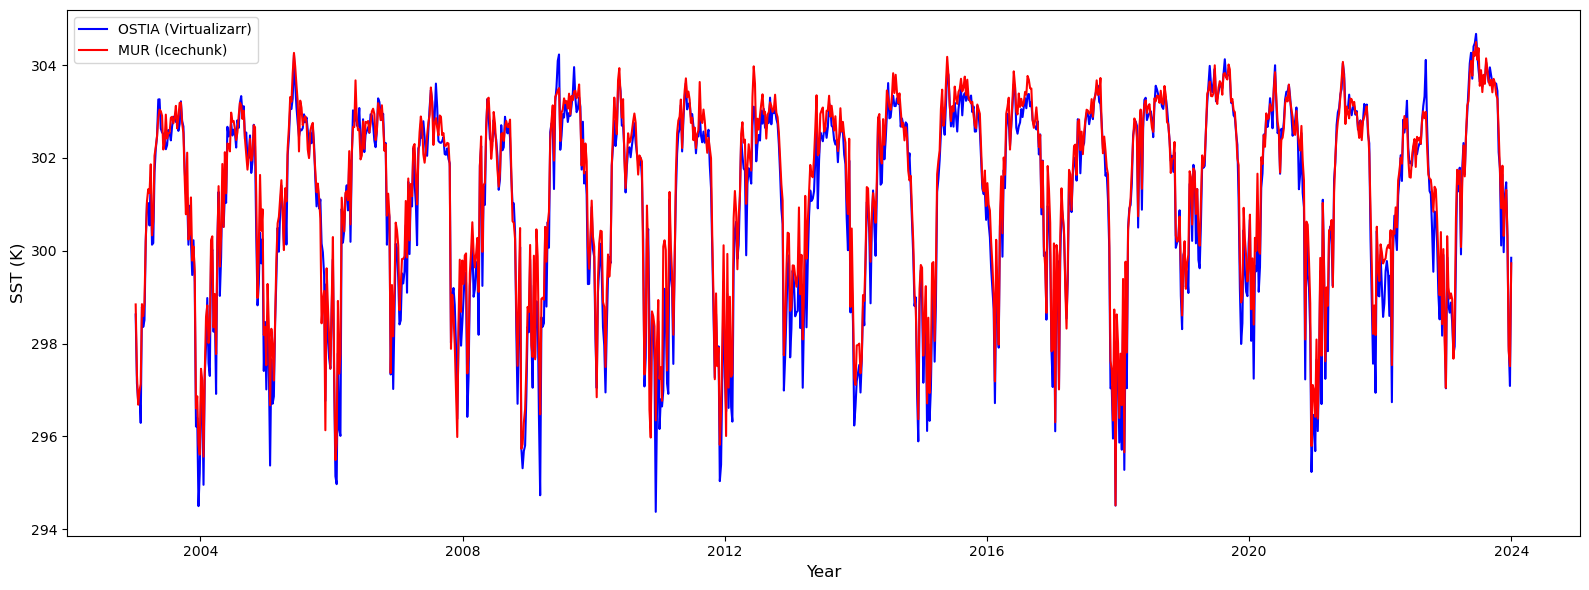

In [102]:
fig = plt.figure(figsize=(16,6), layout="tight")
ax = plt.axes()
plt.plot(ostia_subset["time"].values, ostia_subset, color='blue', label='OSTIA (Virtualizarr)')
plt.plot(mur_subset["time"].values, mur_subset, color='red',label='MUR (Icechunk)' )
plt.xlabel("Year", fontsize=12)
plt.ylabel("SST (K)", fontsize=12)
plt.legend(loc='upper left', )
ax.tick_params(axis='both', which='major', labelsize=10)
plt.show()


## Step 5 Option 2: Read and plot with `zarr-python`

This option requires more data formatting steps, but is found to be faster than xarray. 

#### 5a. Open zarr store

In [10]:
%%time
zarr_store = zarr.open(session.store, mode="r")

CPU times: user 4.62 ms, sys: 40 μs, total: 4.66 ms
Wall time: 5.16 ms


#### 5b. Create datetime array for plotting

In [11]:
%%time
epoch = datetime(1981, 1, 1)
dt_array = np.array([epoch + timedelta(seconds=int(t)) for t in zarr_store['time'][:]])

CPU times: user 6.48 s, sys: 1.58 s, total: 8.06 s
Wall time: 3.97 s


#### 5c. Create slice indices from lat and lon ranges

In [12]:
lat_range = list(lat_range)
lon_range = list(lon_range)
lat_indices = [int((lat - lat_min)/resolution) for lat in lat_range]
lon_indices = [int((lon - lon_min)/resolution) for lon in lon_range]

#### 5d. Subset and load data

In [27]:
%%time
sst_subset = zarr_store["analysed_sst"][:, lat_indices[0]:lat_indices[1], lon_indices[0]:lon_indices[1]]
print(f"Fetched {'{:,}'.format(np.prod(sst_subset.shape))} points")

Fetched 80,370,000 points
CPU times: user 2min 59s, sys: 23.2 s, total: 3min 22s
Wall time: 1min 11s


#### 5e. Mask data

In [28]:
%%time
fill_value = zarr_store["analysed_sst"].fill_value
masked_array = np.ma.masked_equal(sst_subset, fill_value)

CPU times: user 50.3 ms, sys: 48.8 ms, total: 99.1 ms
Wall time: 98.5 ms


#### 5f. Calculate spatial mean over time; add smoothing on a weekly time scale

In [36]:
%%time
sst_mean = masked_array.mean(axis=(1,2))
#window_size = 7  #7 days
#weights = np.ones(window_size) / window_size
#sst_mean = np.convolve(sst_mean, weights, mode='valid')

CPU times: user 59.1 ms, sys: 0 ns, total: 59.1 ms
Wall time: 58.8 ms


#### 5g. Scale result

In [37]:
%%time
sst_attrs = zarr_store["analysed_sst"].metadata.attributes
offset, scale = sst_attrs['add_offset'], sst_attrs['scale_factor']
scaled_sst_mean = (sst_mean*scale) + offset

CPU times: user 2.37 ms, sys: 0 ns, total: 2.37 ms
Wall time: 1.88 ms


#### 5h. Plot data

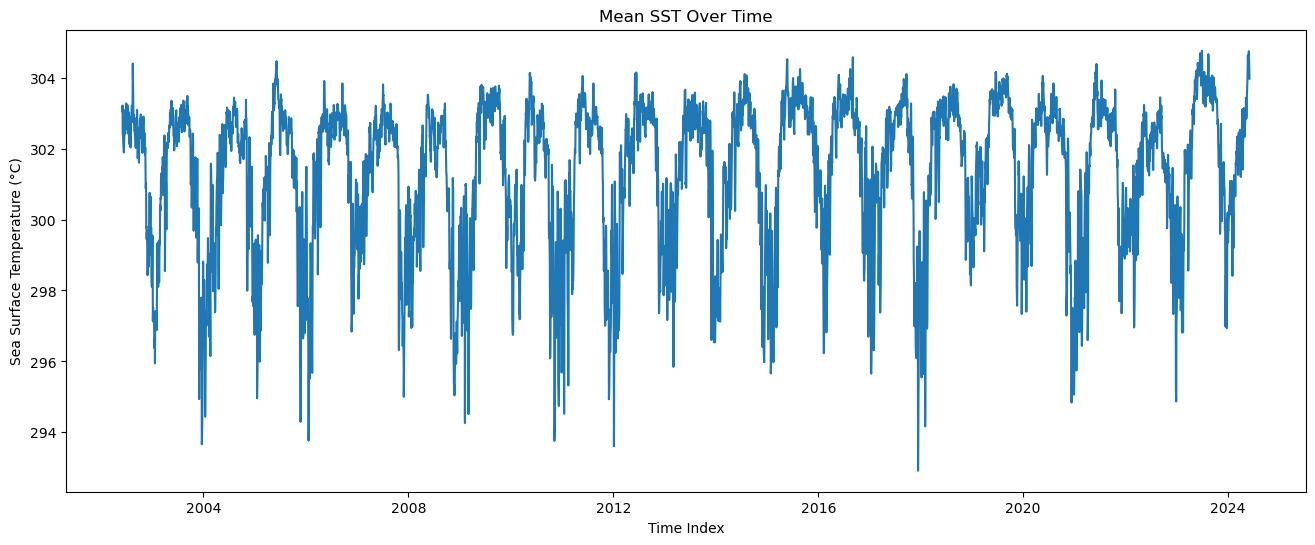

CPU times: user 195 ms, sys: 11.5 ms, total: 206 ms
Wall time: 206 ms


In [38]:
%%time
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot()
plt.plot(dt_array, scaled_sst_mean)
plt.title("Mean SST Over Time")
plt.xlabel("Time Index")
plt.ylabel("Sea Surface Temperature (°C)")  # Replace with correct units
plt.show()

## Step 6: Visualize the data

In [ ]:
# Enable Panel/HoloViews extensions
hv.extension('bokeh')
pn.extension()

# `masked_array` is from the reading icechunk with zarr-python section
scaled_sst = (masked_array*scale) + offset
shape = scaled_sst.shape

# Get number of time steps
n_times = shape[0]

# Create coordinate arrays
times = zarr_store['time'][:]
# `lat_indices` and `lon_indices` are from the reading icechunk with zarr-python section
lats = zarr_store['lat'][lat_indices[0]:lat_indices[1]]
lons = zarr_store['lon'][lon_indices[0]:lon_indices[1]]

In [ ]:
# Create the time index slider
time_slider = pn.widgets.IntSlider(
    name='Time Index', 
    start=0, 
    end=n_times-1, 
    value=0
)

# Create a function to generate the plot for a given time index
def plot_sst(time_idx):
    # Extract the data for the given time step
    time_slice = scaled_sst[time_idx, :, :]
    
    # Format timestamp (adjust based on your time values)
    if isinstance(times[time_idx], np.datetime64):
        time_str = np.datetime_as_string(times[time_idx], unit='D')
    else:
        time_str = f"Step {time_idx}"
    
    # Create a HoloViews Image object
    img = hv.Image((lons, lats, time_slice), kdims=['Longitude', 'Latitude'], vdims=['SST'])
    
    # Apply styling
    img = img.opts(
        opts.Image(
            cmap='turbo',
            colorbar=True,
            clim=(281, 289),
            width=700,
            height=700,
            title=f'Sea Surface Temperature - {time_str}'
        )
    )
    
    return img

# Create a DynamicMap that updates with the slider
dmap = hv.DynamicMap(plot_sst, kdims=['time_idx']).redim.range(time_idx=(0, n_times-1))
# Explicitly bind the DynamicMap to the slider
dmap = dmap.apply(lambda obj: obj.clone(time_idx=time_slider.value))

# Create play/pause widget with a callback to update the slider
player = pn.widgets.Player(
    name='Play',
    start=0,
    end=n_times-1,
    value=0,
    interval=25,  # Update every 200ms - adjust as needed
    loop_policy='loop'
)

# Make sure the player updates the slider, which in turn updates the plot
def update_slider(event):
    time_slider.value = event.new
    
player.param.watch(update_slider, 'value')

# Create a reactive function that outputs a Panel object with the current plot
@pn.depends(time_idx=time_slider)
def get_current_plot(time_idx):
    return plot_sst(time_idx)

# Create the layout
dashboard = pn.Column(
    "## Sea Surface Temperature Time Animation (Direct Zarr)",
    pn.Row(player, time_slider),
    get_current_plot
)

# Display the dashboard
dashboard.servable()